In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

``Data Loading``

In [4]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
df.shape

(1014, 7)

In [7]:
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [8]:
df.tail()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


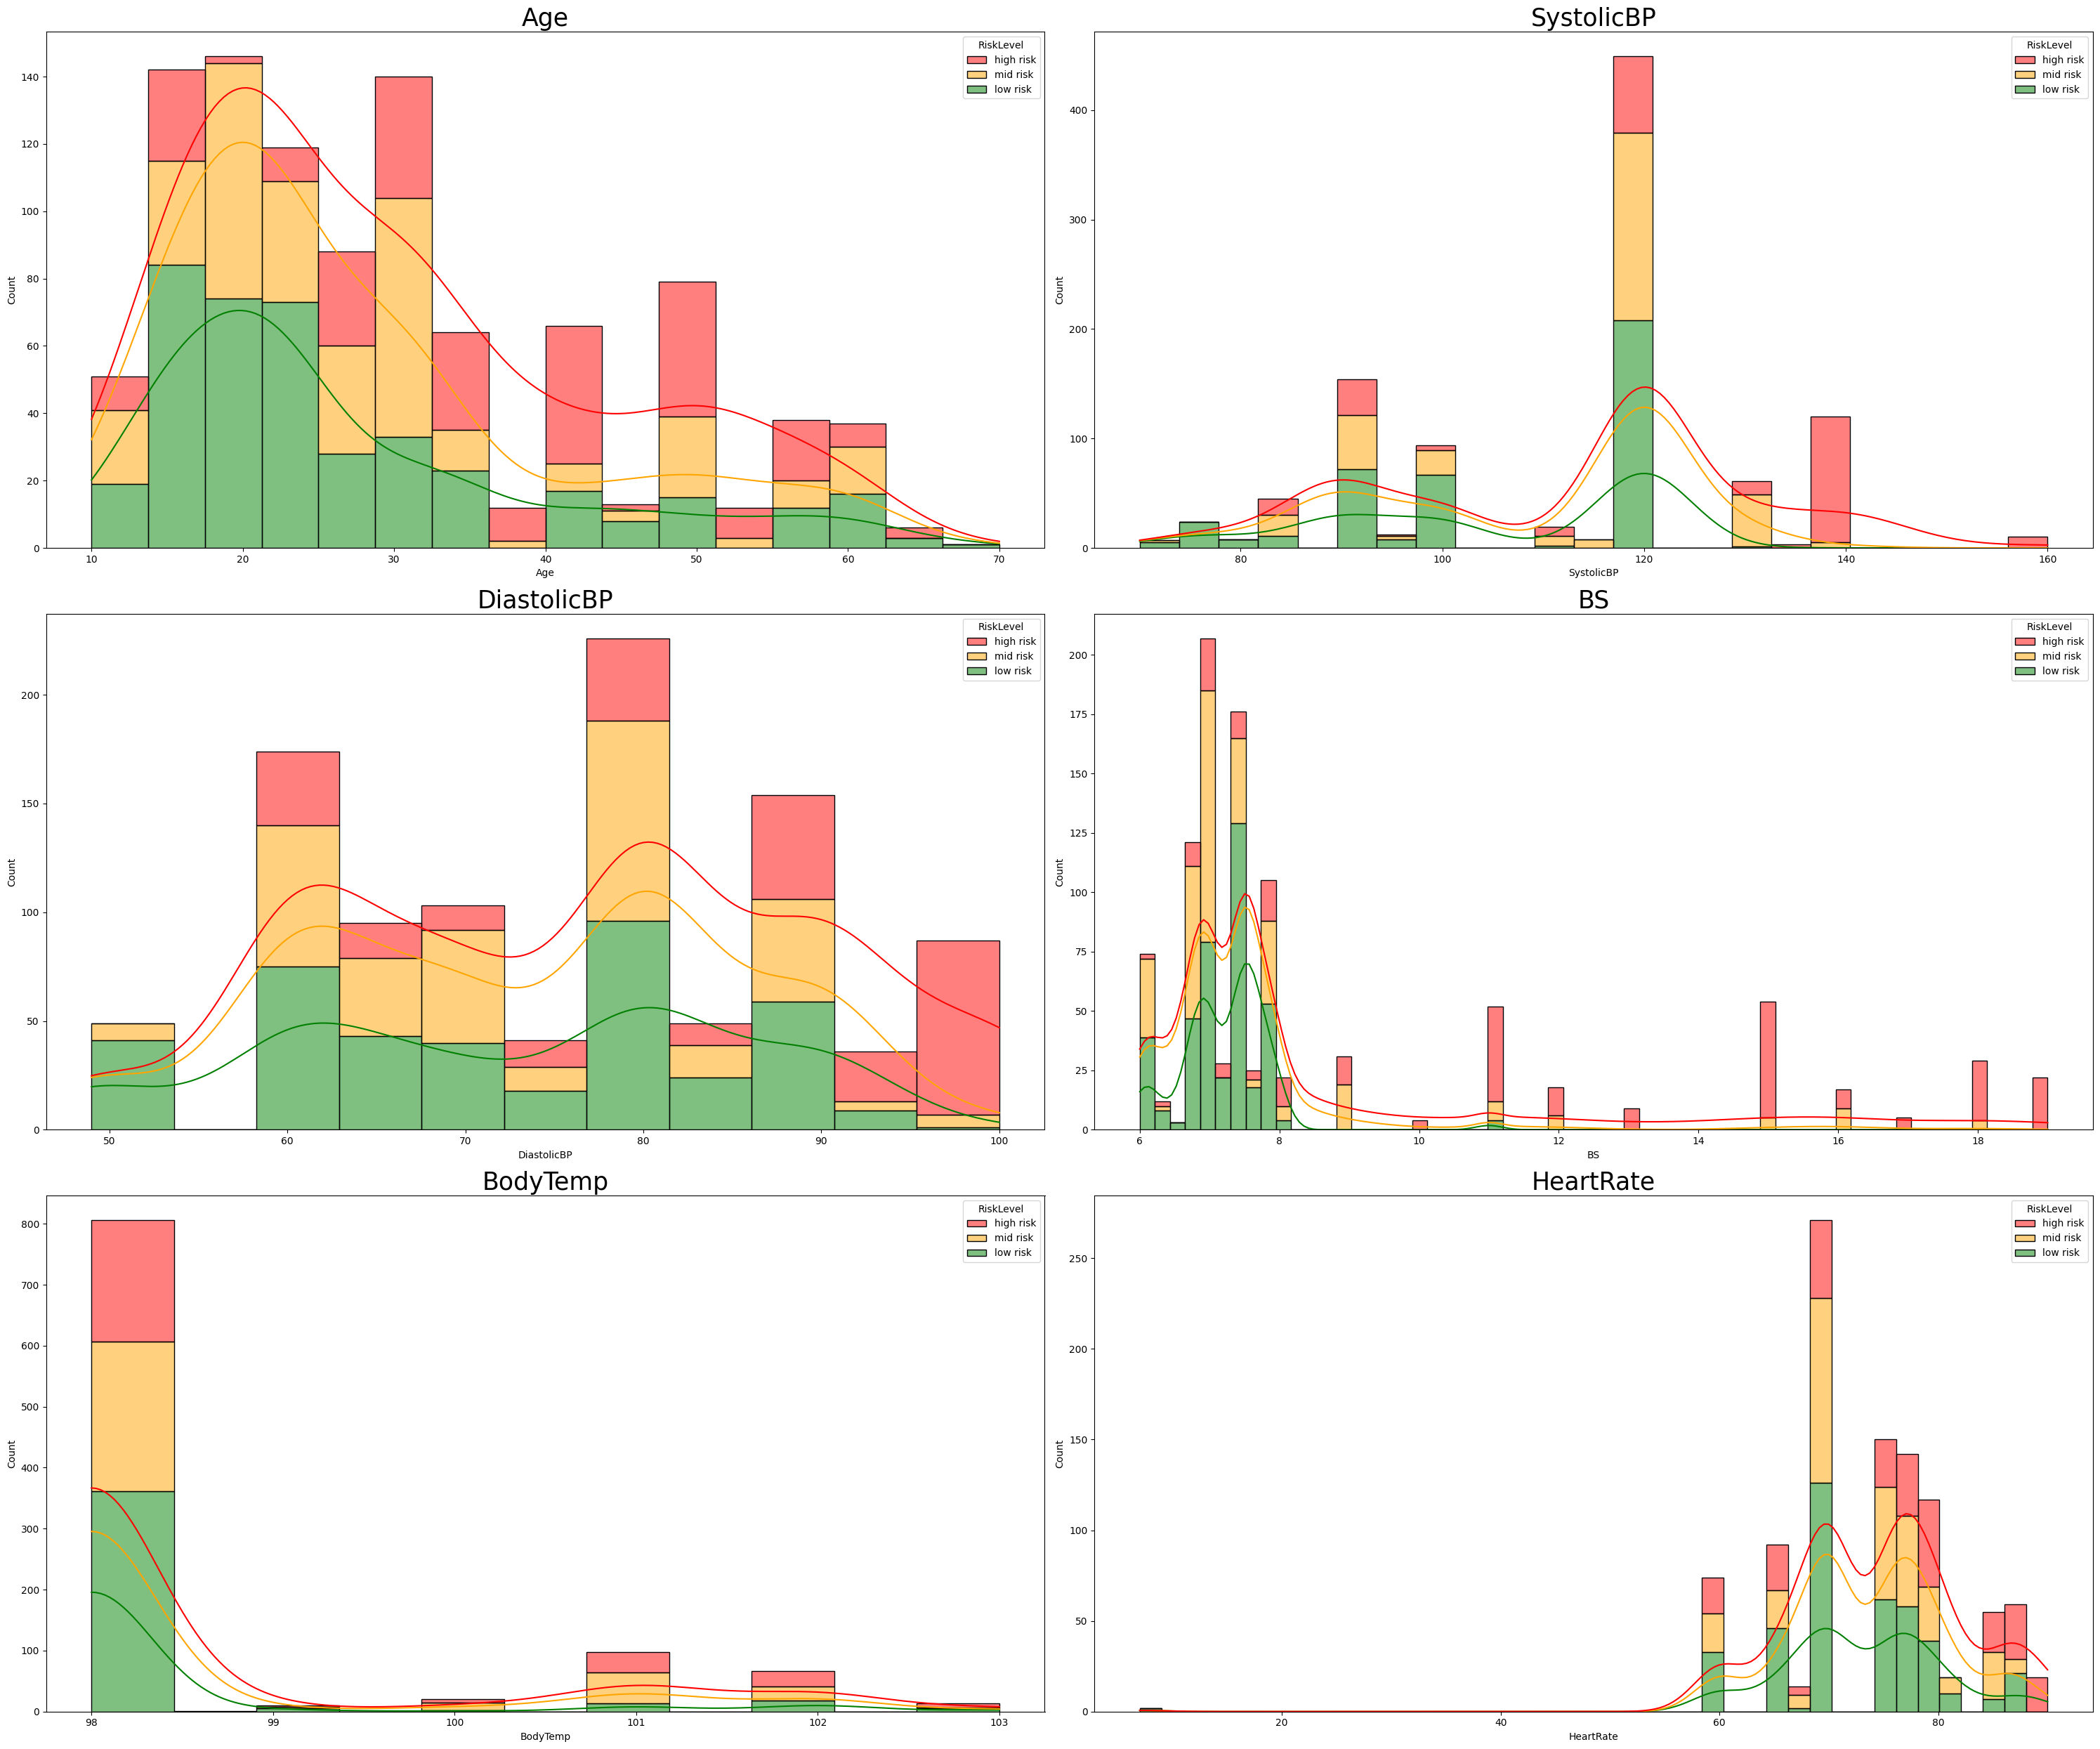

In [26]:
# Plot stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 25))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), df.columns):
    sns.histplot(data=df, 
                 x=column, 
                 kde=True, 
                 hue="RiskLevel", 
                 hue_order=risk_level_order, 
                 multiple="stack",
                 palette={"low risk": "green", "mid risk": "orange", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=25)

plt.tight_layout()
plt.savefig("maternal_features_description.png")
plt.show()

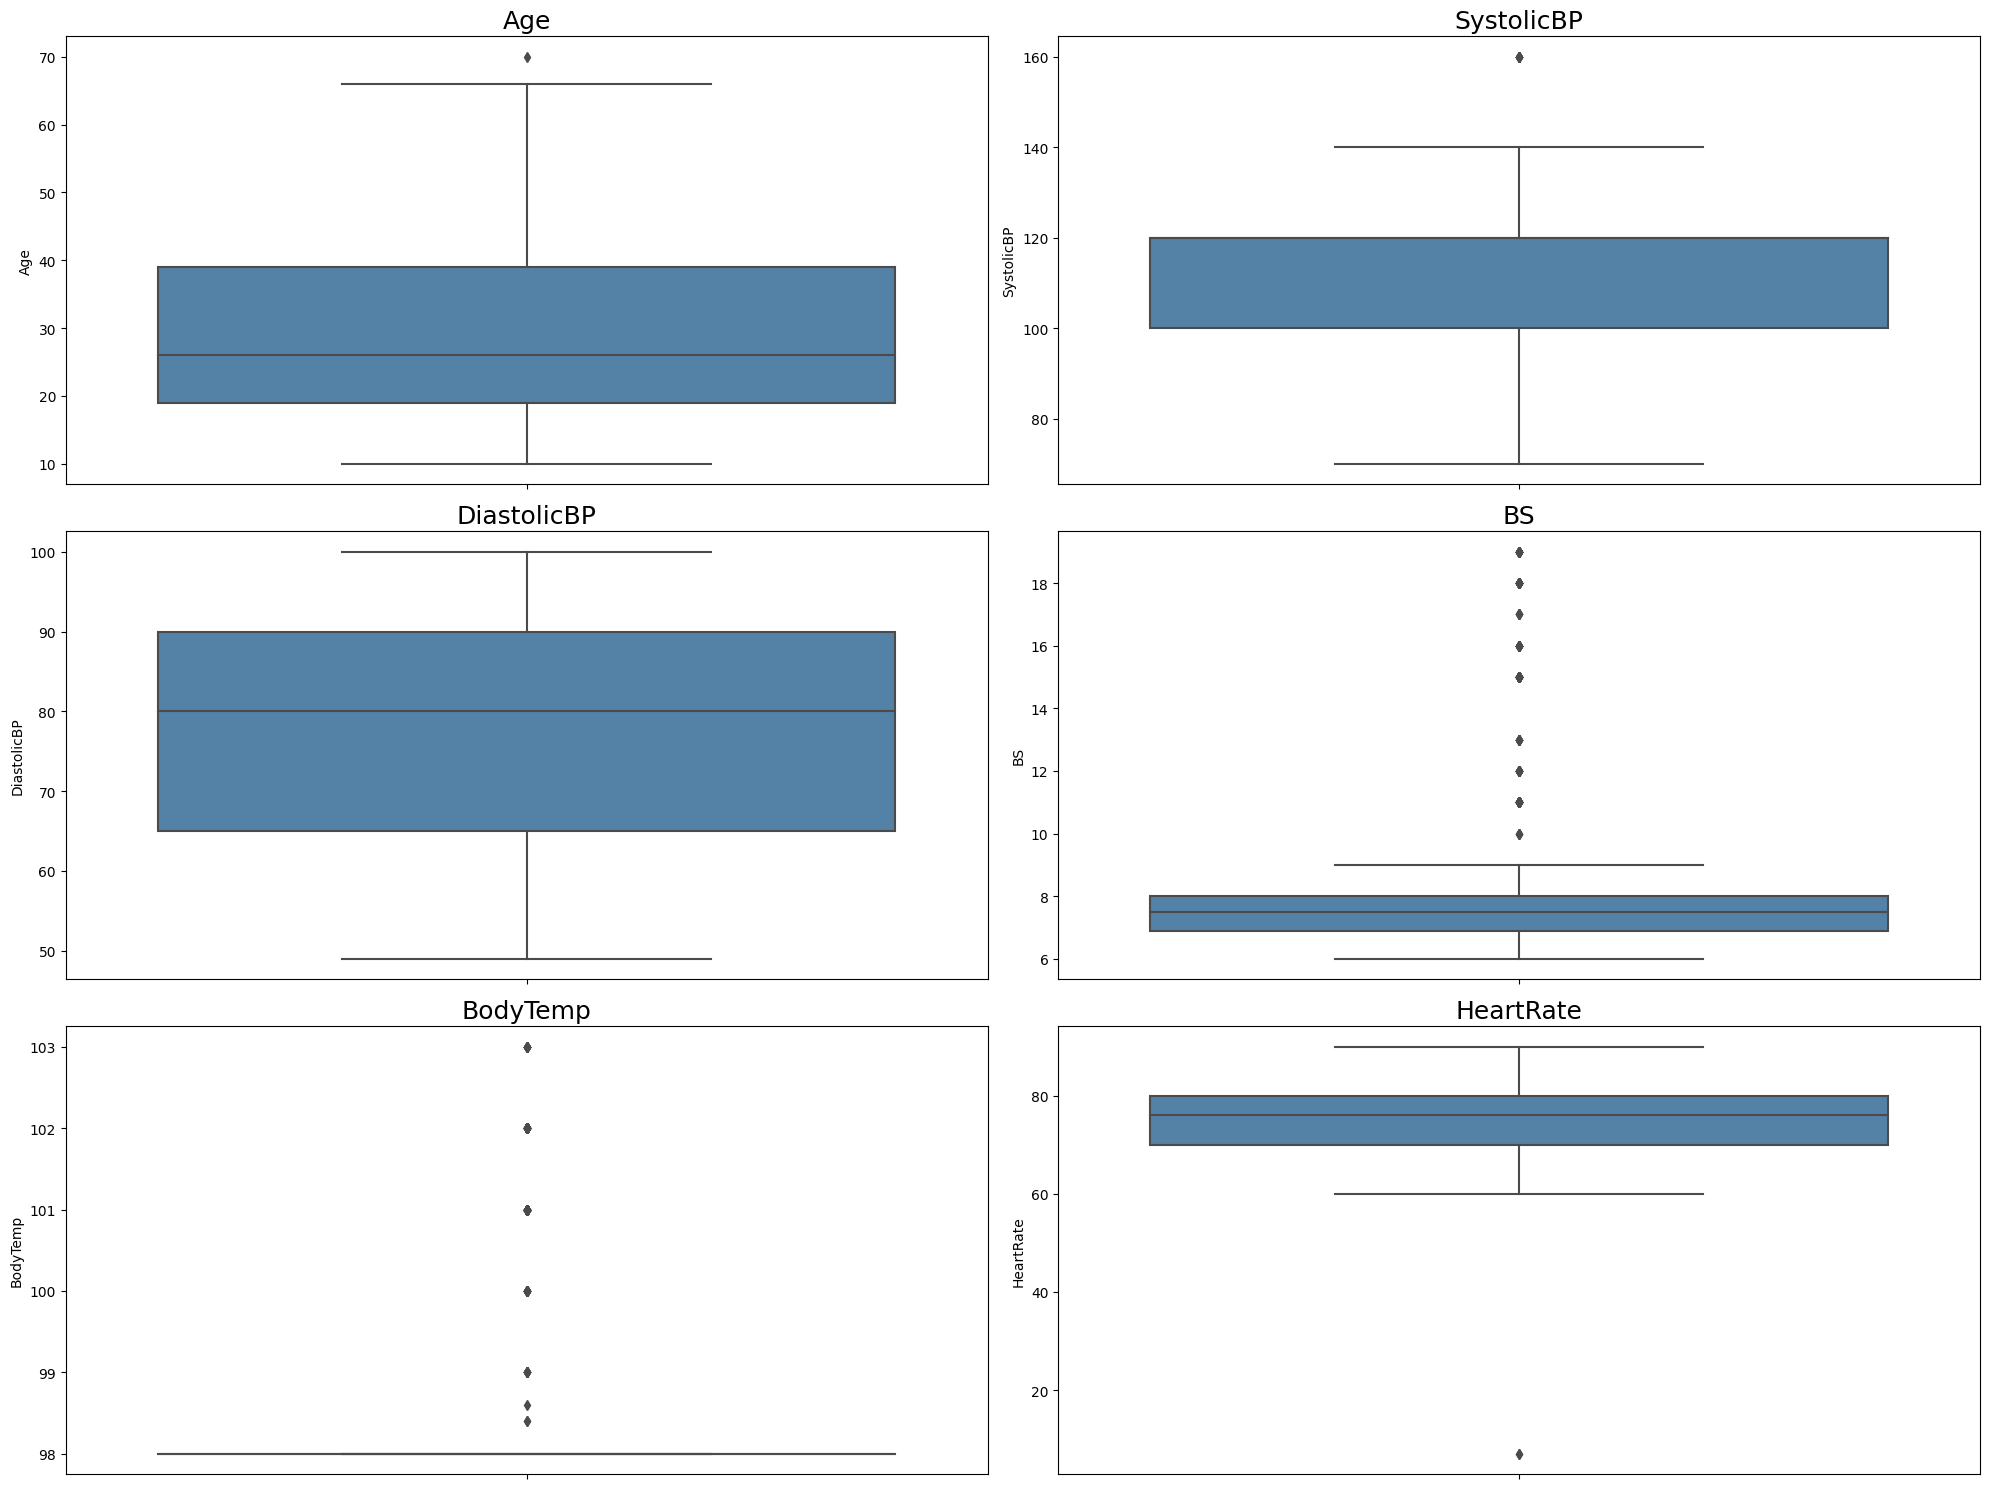

In [27]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df.columns):
    sns.boxplot(y=df[column], 
                color="#4682B4", 
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

`Correlation Analysis of Variables`

In [11]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


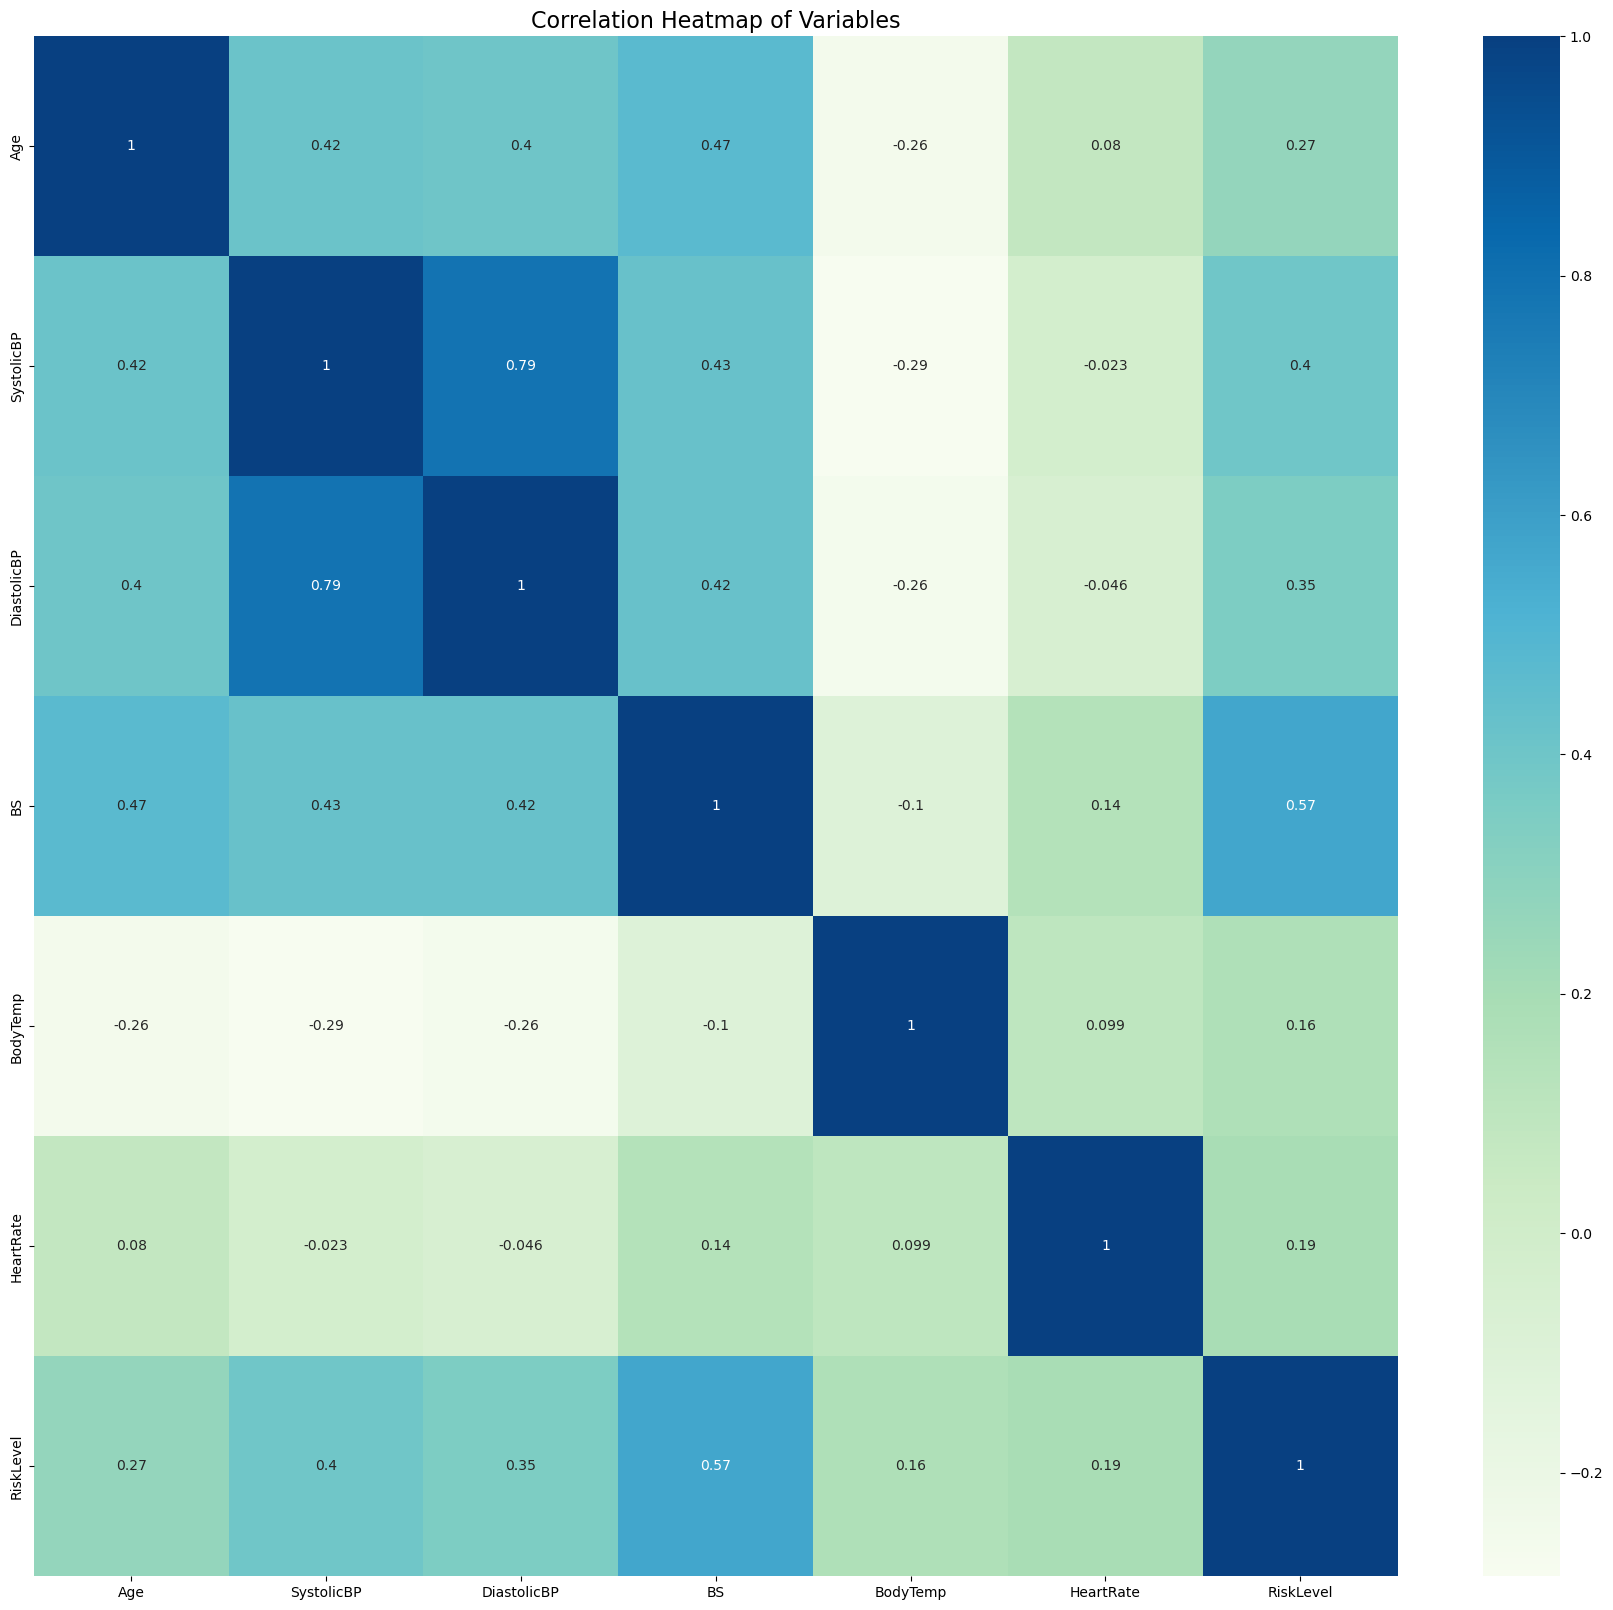

In [12]:
# Create a correlation heatmap
plt.figure(figsize=(22,20))  
sns.heatmap(df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

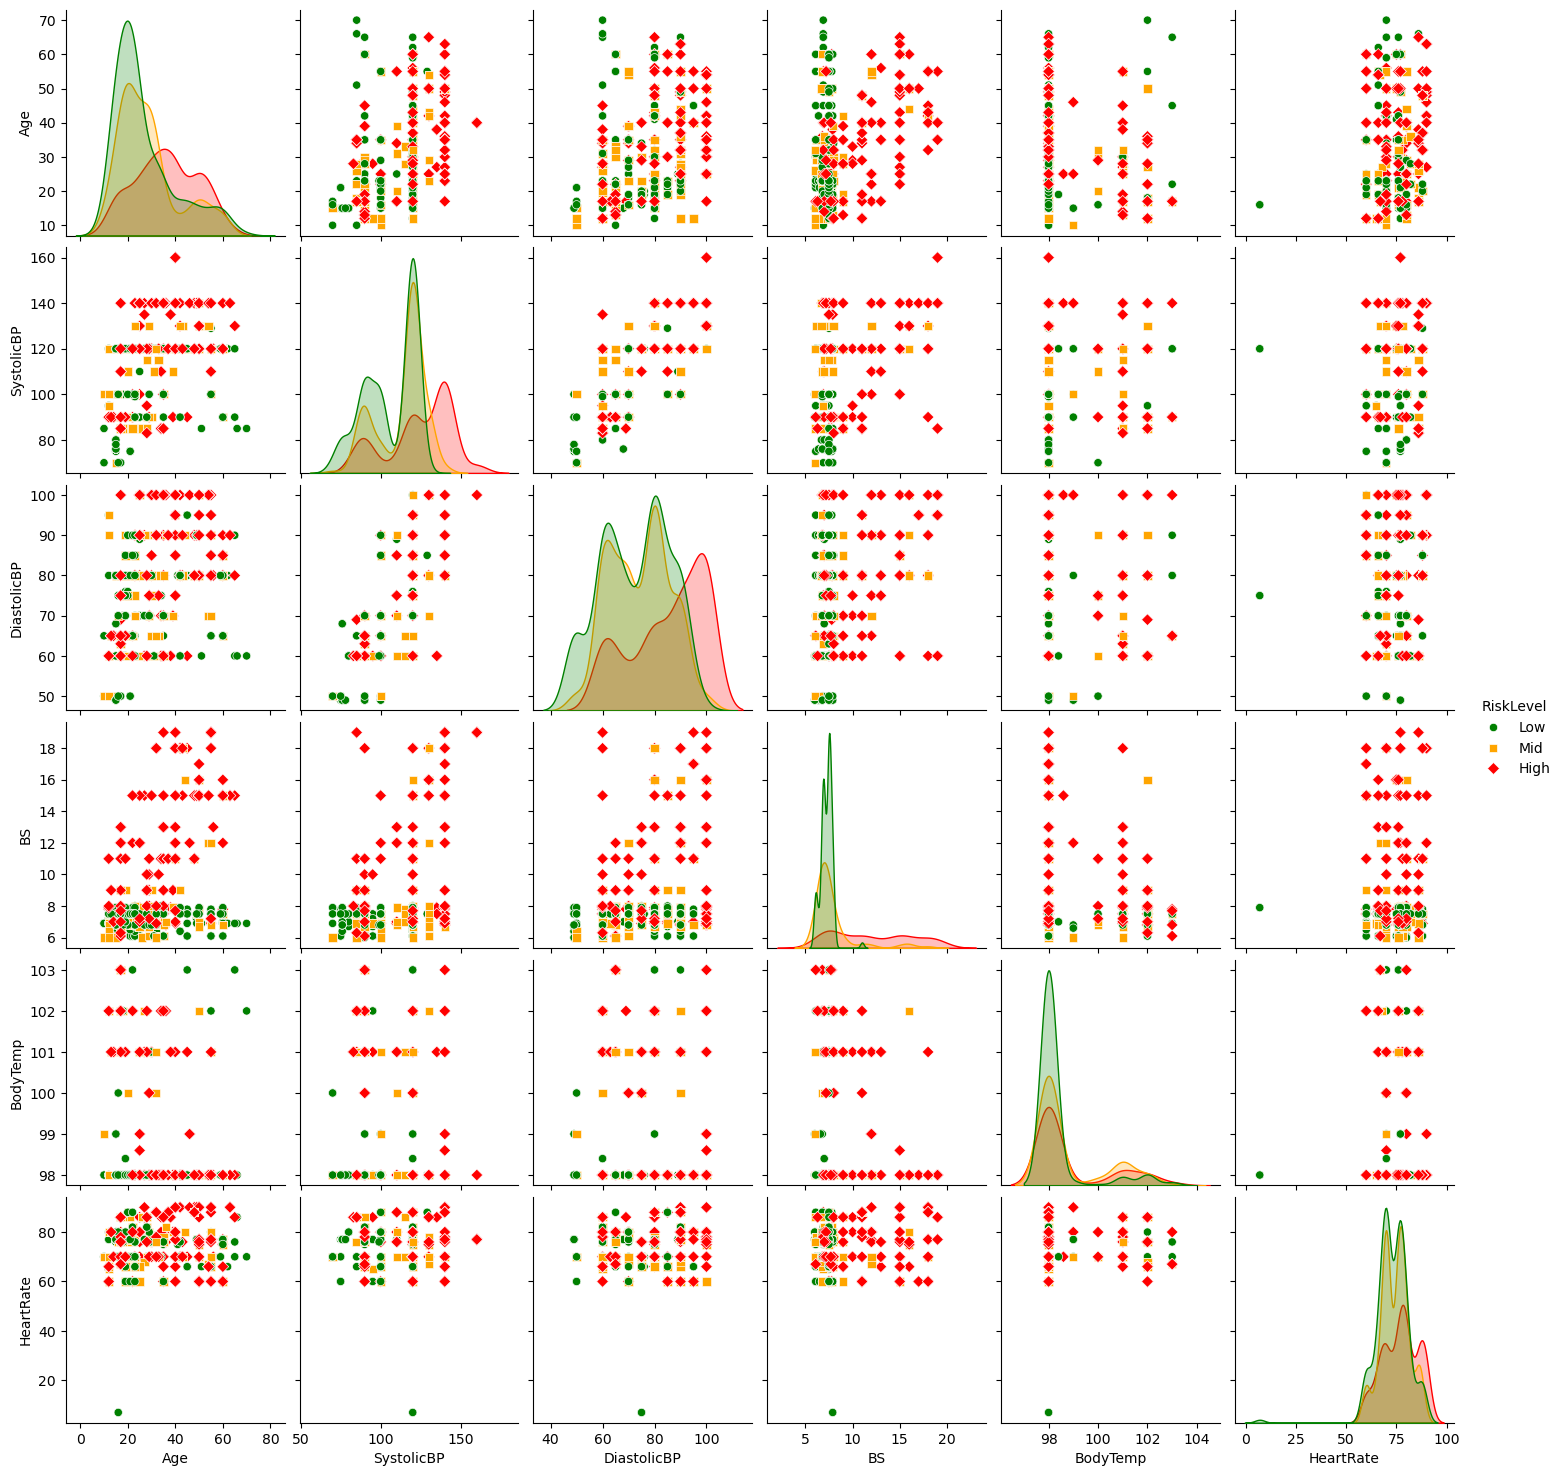

In [13]:
# Create a pairplot with RiskLevel
risk_colors = {0: "green", 1: "orange", 2: "red"}

plot = sns.pairplot(df, hue='RiskLevel', 
                    palette=risk_colors, 
                    markers=["o", "s", "D"])

legend_labels = {"0": "Low", "1": "Mid", "2": "High"}
for text, label in zip(plot._legend.texts, legend_labels.values()):
    text.set_text(label)
plt.savefig("maternal_pairplot_to_see_patterns.png")
plt.show()

In [14]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [15]:
# Drop SystolicBP for model training
df = df.drop(["SystolicBP"], axis=1)

In [16]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

908     7
499     7
702    60
783    60
784    60
Name: HeartRate, dtype: int64

In [17]:
# Remove the outlier in HeartRate
df = df.drop(df.index[df.HeartRate == 7])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


<h3>Model Building</h3>

In [19]:
# Feature scaling
columns = ["Age", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
scale_X = StandardScaler()
X = pd.DataFrame(scale_X.fit_transform(df.drop(["RiskLevel"],axis = 1),), columns = columns)
y = df["RiskLevel"]

In [20]:
X.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.363796,0.254566,1.903633,-0.485808,1.538308
1,0.378765,0.974379,1.296644,-0.485808,-0.589878
2,-0.066772,-0.465247,-0.220828,0.972192,0.740239
3,0.007484,0.614473,-0.524323,-0.485808,-0.589878
4,0.378765,-1.185059,-0.797468,-0.485808,0.208192


In [21]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

**Logistic Regression**

In [22]:
# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.64


In [23]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.6037037  0.5962963  0.57992565]
CrossValMeans: 0.593
CrossValStandard Deviation: 0.01


In [24]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [25]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(), 
                                param_grid=params_LR, 
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True,
                                )

In [26]:
GridSearchCV_LR.fit(X_train, y_train);

In [27]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.602


In [28]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [29]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

Confusion Matrix:
[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


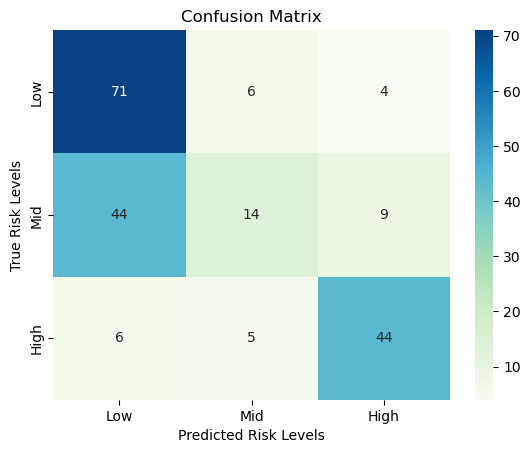

In [30]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");  
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

**K-Nearest Neighbors**

In [31]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)


Baseline K-Nearest Neighbors: 0.66


In [32]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.61481481 0.66666667 0.64684015]
CrossValMeans: 0.643
CrossValStandard Deviation: 0.021


In [33]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [34]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [35]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train);

c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [36]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best parameter values:
{'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.795


In [37]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)


In [38]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


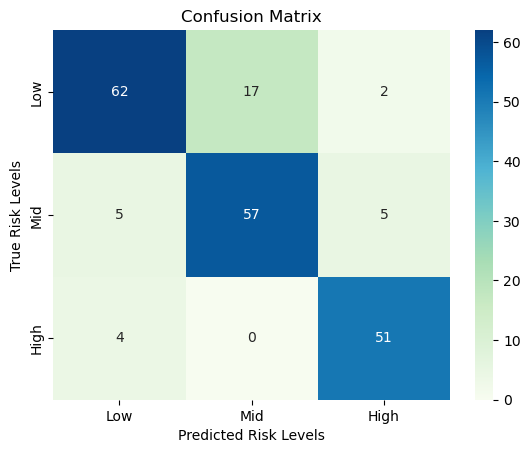

In [39]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

**Random Forest**

In [40]:
# Baseline model of Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest_mod = random_forest.fit(X_train, y_train)
print(f"Baseline Random Forest: {round(random_forest_mod.score(X_test, y_test), 3)}")
pred_random_forest = random_forest_mod.predict(X_test)

Baseline Random Forest: 0.837


In [41]:
# Cross validate Random Forest Classifier model
scores_RF = cross_val_score(random_forest, X_train, y_train, cv=3, scoring = "accuracy")
print(f"Scores(Cross validate) for Random forest model:\n{scores_RF}")
print(f"CrossValMeans: {round(scores_RF.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_RF.std(), 3)}")

Scores(Cross validate) for Random forest model:
[0.80740741 0.8037037  0.82527881]
CrossValMeans: 0.812
CrossValStandard Deviation: 0.009


In [42]:
# Test with new parameter
random_forest = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
random_forest_mod = random_forest.fit(X_train, y_train)
pred_random_forest = random_forest_mod.predict(X_test)



In [43]:
print("Classification Report")
print(classification_report(y_test, pred_random_forest))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_random_forest))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        81
           1       0.79      0.79      0.79        67
           2       0.87      0.96      0.91        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[64 14  3]
 [ 9 53  5]
 [ 2  0 53]]


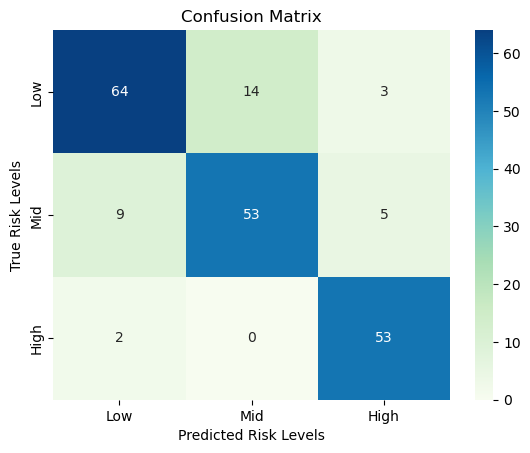

In [44]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_random_forest), annot=True, ax = ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels"); 
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

In [45]:
# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest"],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(logistic_regression_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(knn_mod, X_train, y_train, cv=3).mean(),
        cross_val_score(random_forest_mod, X_train, y_train, cv=3).mean()
        
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        logistic_regression_mod.score(X_test, y_test),
        knn_mod.score(X_test, y_test),
        random_forest_mod.score(X_test, y_test),
        
    ]
})
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [logistic_regression_mod, knn_mod, random_forest_mod]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df


,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.837438,K-Nearest Neighbors,0.794818,0.840899,0.837438,0.836922
0.837438,Random Forest,0.810891,0.836980,0.837438,0.836060
0.635468,Logistic Regression,0.601960,0.628104,0.635468,0.593824


In the evaluation of model performance, the KNN algorithm emerges as the standout performer among the considered models. With a test accuracy of 83.7%, it surpasses both the Logistic Regression and Random Forest models, which exhibit commendable test accuracies of 83.74% each. Moreover, this model demonstrates superior precision, recall, and F1 score, reflecting a well-balanced performance across various evaluation metrics. Conversely, the Logistic Regression model consistently lags in all metrics, highlighting its comparatively lower effectiveness.

In [47]:
import joblib

In [49]:
joblib.dump( knn_mod,'maternal_model.sav')

['maternal_model.sav']